In [51]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import glob
import pickle as pkl
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
import os

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [3]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [221]:
epl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels'
spl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/surface'

regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5),([-7.5,-81],[-3.7,-74])],
'central' : [(-12,-8), ([-10.5,-81],[-6.5,-72])],   # mid:
'southern' : [(-18,-12), ([-17.9,-74.5],[-9.5,-68.5])]}
h = 2000

In [222]:
region = 'central'
alls = regions[region]
ccords = alls[1]

In [187]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [188]:
corr_start = dic['start_3d']
corr_end = dic['end_5d']
corr_start.name = 'r'
corr_end.name = 'r'

In [189]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0)
dummy = uda.flip_lat(dummy)

In [190]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-85,-55), lat=slice(-25,3))
topo_on_g = dummy.salem.lookup_transform(topo)

In [10]:
corrs_on_g = dummy.salem.transform(corr_start, interp='nearest').where(topo_on_g>=2000)
corre_on_g = dummy.salem.transform(corr_end, interp='nearest').where(topo_on_g>=2000)

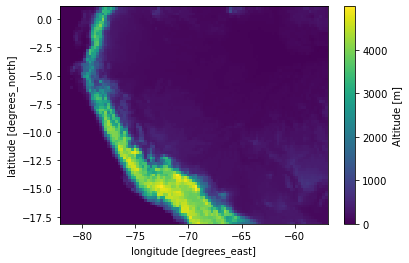

In [11]:
topo_on_g.plot()

In [201]:
start = ccords[0]
end = ccords[1]

In [219]:
topo_on_g.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc', mode='w', format='NETCDF4')

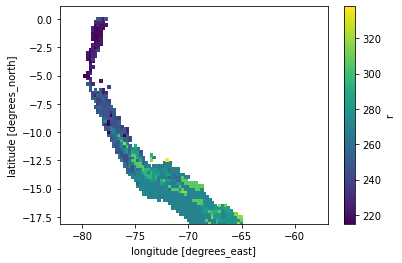

In [62]:
corrs_on_g.plot()

In [85]:
def readERA(r):
    epl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc'
    inputs = glob.glob(epl)
    alls = regions[r]
    
    doys = corrs_on_g.sel(latitude=slice(alls[0][0], alls[0][1])).mean()
    doye = corre_on_g.sel(latitude=slice(alls[0][0], alls[0][1])).mean()
    dsdate = pd.Timestamp('2008-01-01')+pd.Timedelta(str(doys.values)+'days')
    dedate = pd.Timestamp('2008-01-01')+pd.Timedelta(str(doye.values)+'days')
    
    alist = []
    for file in inputs:
        fbasename = os.path.basename(file)
        y = fbasename[5:9]
        m = fbasename[10:12]
        d = fbasename[13:15]
        if (int(y)<1985) | (int(y)>2018):
            continue
        date = pd.Timestamp(y+'-'+m+'-'+d)
        ddoy = date.dayofyear
        print('Doing ', file)
        if (ddoy<doys) & (ddoy>doye):  # check rainy season start end
            print(r, 'start season:', dsdate, 'end season:', dedate)
            print('Outside of rainy season, continue')
            continue

        
        u200orig = xr.open_dataset(file)
        u200orig = uda.flip_lat(u200orig)
        u200orig = u200orig.sel(latitude=slice(alls[0][0], alls[0][1]), time=(u200orig['time.hour']==15)).mean('latitude')
        u200orig = u200orig.drop(['pv'])
        datetimes = pd.to_datetime(u200orig.time.values)
        newtimes = []
        for t in datetimes:
            newtimes.append(t.replace(hour=0))
        u200orig['time'] = ('time', newtimes)
        alist.append(u200orig)
    ds = xr.concat(alist, dim='time')
    
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars} #{var: comp}
    ds.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+r+'_cross_15UTC_1985-2018_peru.nc', mode='w',
                       encoding=encoding, format='NETCDF4')

In [ ]:
readERA('transition')

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_26_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_18_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_07_16_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end season: 2008-06-12 07:51:43.448284800
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_198

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_27_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_28_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_29_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_30_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_31_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_20_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_05_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_05_23_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_24_pl.nc
transition start season: 2008-08-31 05:22:45.517238400 end s

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_01_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_02_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_03_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_04_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_05_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_06_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_09_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_10_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_12_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_13_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pres